# Lesson 11: Multimodal

This notebook demonstrates how to build multimodal AI systems that can process and understand both text and visual content using Google's Gemini models. You'll learn to work with images and PDFs in various formats, implement multimodal RAG systems for semantic search, and create AI agents capable of visual reasoning.

We will use the `google-genai` library to interact with Google's Gemini models.

**Learning Objectives:**

1. **Process multimodal content**: Learn to handle images and PDFs in different formats (bytes, base64, URLs) with Gemini models
2. **Implement object detection**: Use multimodal LLMs for visual analysis and structured output generation
3. **Build multimodal RAG systems**: Create embeddings for images and text to enable semantic search across visual content
4. **Develop multimodal AI agents**: Construct ReAct agents that can search through and reason about visual information

## 1. Setup

First, let's install the necessary Python libraries using pip.

!pip install -q google-genai pydantic python-dotenv

### Configure Gemini API Key

To use the Gemini API, you need an API key. 

1.  Get your key from [Google AI Studio](https://aistudio.google.com/app/apikey).
2.  Create a file named `.env` in the root of this project.
3.  Add the following line to the `.env` file, replacing `your_api_key_here` with your actual key:
    ```
    GOOGLE_API_KEY="your_api_key_here"
    ```
The code below will load this key from the `.env` file.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lessons.utils import env

env.load(required_env_vars=["GOOGLE_API_KEY"])

Trying to load environment variables from `/Users/pauliusztin/Documents/01_projects/TAI/course-ai-agents/.env`
Environment variables loaded successfully.


### Import Key Packages

In [3]:
import base64
import io
from pathlib import Path
from typing import Literal

from google import genai
from google.genai import types
from IPython.display import Image as IPythonImage
from PIL import Image as PILImage

from lessons.utils import pretty_print

### Initialize the Gemini Client

In [4]:
client = genai.Client()

### Define Constants

We will use the `gemini-2.5-flash` model, which is fast, cost-effective, and supports advanced features like tool use.

In [5]:
MODEL_ID = "gemini-2.5-flash"

## 2. Applying multimodal LLMs to images, PDFs, and text

There are three core ways we can process images and PDFs with multimodal models:
1. As raw bytes
2. As base64 encoded strings
3. As URLs

First, let's examine a test image:


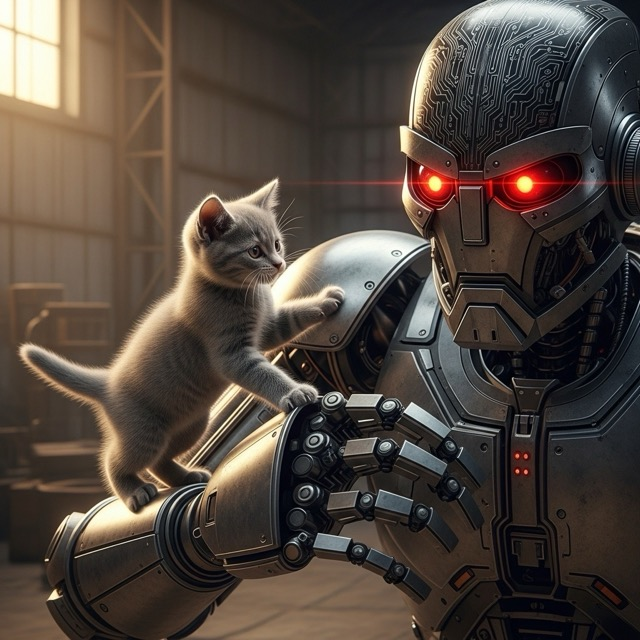

In [6]:
def display_image(image_path: Path) -> None:
    """
    Display an image from a file path in the notebook.

    Args:
        image_path: Path to the image file to display

    Returns:
        None
    """

    image = IPythonImage(filename=image_path, width=400)
    display(image)


display_image(Path("images") / "image_1.jpeg")

### 2.1 As raw bytes

In [7]:
def load_image_as_bytes(
    image_path: Path, format: Literal["WEBP", "JPEG", "PNG"] = "WEBP", max_width: int = 600, return_size: bool = False
) -> bytes | tuple[bytes, tuple[int, int]]:
    """
    Load an image from file path and convert it to bytes with optional resizing.

    Args:
        image_path: Path to the image file to load
        format: Output image format (WEBP, JPEG, or PNG). Defaults to "WEBP"
        max_width: Maximum width for resizing. If image width exceeds this, it will be resized proportionally. Defaults to 600
        return_size: If True, returns both bytes and image size tuple. Defaults to False

    Returns:
        bytes: Image data as bytes, or tuple of (bytes, (width, height)) if return_size is True
    """

    image = PILImage.open(image_path)
    if image.width > max_width:
        ratio = max_width / image.width
        new_size = (max_width, int(image.height * ratio))
        image = image.resize(new_size)

    byte_stream = io.BytesIO()
    image.save(byte_stream, format=format)

    if return_size:
        return byte_stream.getvalue(), image.size

    return byte_stream.getvalue()

In [8]:
image_bytes = load_image_as_bytes(image_path=Path("images") / "image_1.jpeg", format="WEBP")

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        types.Part.from_bytes(
            data=image_bytes,
            mime_type="image/webp",
        ),
        "Tell me what is in this image in one paragraph.",
    ],
)
pretty_print.wrapped(response.text, title="Image 1 Caption")


----------------------------------------- Image 1 Caption -----------------------------------------
  The image depicts an imposing metallic robot with a detailed, circuit-etched head and intense glowing red eyes. A tiny, fluffy grey tabby kitten is playfully perched on the robot's large metallic arm, its front paws reaching towards the robot's shoulder as it looks up. The robot's left hand is open, resting near the kitten. The scene unfolds in what appears to be an industrial workshop or hangar, with a large window in the background casting a soft light on the metallic surroundings and structural beams, creating a striking contrast between the formidable technology and the delicate, curious kitten.
----------------------------------------------------------------------------------------------------


Using the same approach, we can easily pass multiple images simultaneously:

In [9]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        types.Part.from_bytes(
            data=load_image_as_bytes(image_path=Path("images") / "image_1.jpeg", format="WEBP"),
            mime_type="image/webp",
        ),
        types.Part.from_bytes(
            data=load_image_as_bytes(image_path=Path("images") / "image_2.jpeg", format="WEBP"),
            mime_type="image/webp",
        ),
        "What's the difference between these two images? Describe it in one paragraph.",
    ],
)
pretty_print.wrapped(response.text, title="Differences between images")


------------------------------------ Differences between images ------------------------------------
  The most striking difference between the two images lies in the nature of the interaction depicted between the robots and animals, as well as their respective environments. The first image presents a surprisingly gentle scene, with a small, grey kitten playfully exploring the arm of a large, metallic robot, whose red eyes, typically menacing, seem to gaze upon the creature with curiosity in an industrial setting. Conversely, the second image portrays a starkly confrontational scenario, where a large, fluffy white dog and a sleek black robot are locked in an aggressive standoff, both in attack poses amidst a cluttered, derelict urban alleyway, creating a clear contrast between a moment of unexpected tenderness and an impending battle.
----------------------------------------------------------------------------------------------------


### 2.2 As base64 encoded strings


In [10]:
from typing import cast


def load_image_as_base64(
    image_path: Path, format: Literal["WEBP", "JPEG", "PNG"] = "WEBP", max_width: int = 600, return_size: bool = False
) -> str:
    """
    Load an image and convert it to base64 encoded string.

    Args:
        image_path: Path to the image file to load
        format: Output image format (WEBP, JPEG, or PNG). Defaults to "WEBP"
        max_width: Maximum width for resizing. If image width exceeds this, it will be resized proportionally. Defaults to 600
        return_size: Parameter passed to load_image_as_bytes function. Defaults to False

    Returns:
        str: Base64 encoded string representation of the image
    """

    image_bytes = load_image_as_bytes(image_path=image_path, format=format, max_width=max_width, return_size=False)

    return base64.b64encode(cast(bytes, image_bytes)).decode("utf-8")

In [11]:
image_base64 = load_image_as_base64(image_path=Path("images") / "image_1.jpeg", format="WEBP")
pretty_print.wrapped(f"{image_base64[:100]}...", title="Image 1 Base64")

------------------------------------------ Image 1 Base64 ------------------------------------------
  UklGRmCtAABXRUJQVlA4IFStAABQ7AKdASpYAlgCPm0ylEekIqInJnQ7gOANiWdtk7FnEo2gDknjPixW9SNSb5P7IbBNhLn87Vtp...
----------------------------------------------------------------------------------------------------


In [12]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        types.Part.from_bytes(data=image_base64, mime_type="image/webp"),
        "Tell me what is in this image in one paragraph.",
    ],
)
response.text


'The image presents a striking juxtaposition of artificial intelligence and natural innocence, featuring a formidable, dark metallic robot with luminous red eyes and intricate circuit board patterns on its head and upper body. Perched on its extended forearm is a small, fluffy grey tabby kitten, which appears to be curiously exploring its metallic perch with a raised paw. The background suggests an industrial or workshop environment, with large metal structures and a soft, warm light filtering in from an upper window, adding a contrasting touch of warmth to the otherwise stark metallic scene.'

### 2.3 As URLs

At the time of writing this notebook, Gemini works well primarily with GCP Cloud Storage links, which are excellent for production use cases but complicate our simple demonstration.

The code would not change much and would look like this:
```python
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        types.Part.from_uri(uri="gs://gemini-images/image_1.jpeg", mime_type="image/webp"),
        "Tell me what is in this image in one paragraph.",
    ],
)
```

### 2.4 Object detection with LLMs

As a more exciting example, let's do object detection with multimodal LLMs.

In [13]:
from pydantic import BaseModel, Field


class BoundingBox(BaseModel):
    ymin: float
    xmin: float
    ymax: float
    xmax: float
    label: str = Field(default="The object found within the bounding box.")


class Detections(BaseModel):
    bounding_boxes: list[BoundingBox]


client = genai.Client()
prompt = """
Detect all of the prominent items in the image. The box_2d should be [ymin, xmin, ymax, xmax] normalized to 0-1000.
"""

image_bytes, image_size = load_image_as_bytes(
    image_path=Path("images") / "image_1.jpeg", format="WEBP", return_size=True
)

config = types.GenerateContentConfig(
    response_mime_type="application/json",
    response_schema=Detections,
)

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        types.Part.from_bytes(
            data=image_bytes,
            mime_type="image/webp",
        ),
        prompt,
    ],
    config=config,
)

width, height = image_size
print("Image size: ", width, height)
detections = cast(Detections, response.parsed)

for bounding_box in detections.bounding_boxes:
    bounding_box.ymin = int(bounding_box.ymin / 1000 * height)
    bounding_box.xmin = int(bounding_box.xmin / 1000 * width)
    bounding_box.ymax = int(bounding_box.ymax / 1000 * height)
    bounding_box.xmax = int(bounding_box.xmax / 1000 * width)
    print(bounding_box)

Image size:  600 600
ymin=166 xmin=219 ymax=586 xmax=598 label='robot'
ymin=162 xmin=22 ymax=415 xmax=336 label='kitten'


For fun, let's visualize the bounding boxes: 

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


def visualize_detections(detections: Detections, image_path: Path) -> None:
    """
    Visualize detected bounding boxes on an image with red rectangles and labels.

    Args:
        detections: Detections object containing bounding boxes with pixel coordinates
        image_path: Path to the image file to visualize

    Returns:
        None: Displays the image with bounding boxes in the notebook
    """

    image = PILImage.open(image_path)
    image_array = np.array(image)

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.imshow(image_array)

    for bbox in detections.bounding_boxes:
        # Calculate box dimensions (matplotlib uses bottom-left corner + width/height)
        width = bbox.xmax - bbox.xmin
        height = bbox.ymax - bbox.ymin

        # Create rectangle patch (x, y is bottom-left corner)
        rect = patches.Rectangle((bbox.xmin, bbox.ymin), width, height, linewidth=3, edgecolor="red", facecolor="none")

        # Add rectangle to the plot
        ax.add_patch(rect)

        # Add label text (positioned at bottom-left of bounding box)
        ax.text(
            bbox.xmin,
            bbox.ymax + 5,  # Slightly below the box
            bbox.label,
            fontsize=12,
            color="red",
            fontweight="bold",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
        )

    # Remove axis ticks and labels for cleaner display
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Object Detection Results: {image_path.name}", fontsize=14, fontweight="bold")

    plt.tight_layout()
    plt.show()

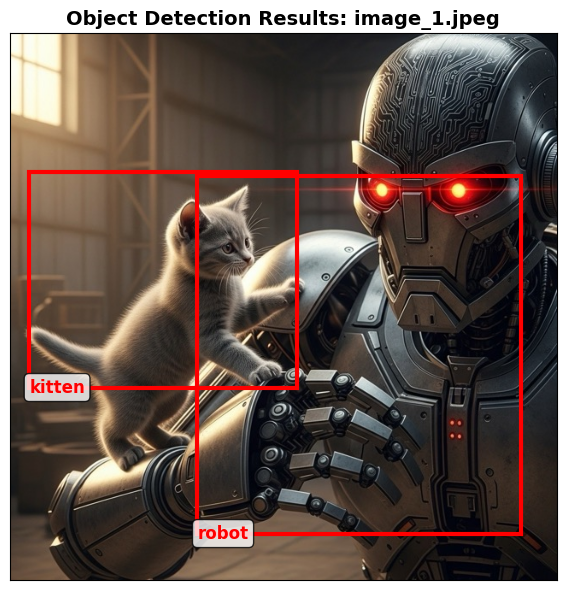

In [15]:
visualize_detections(detections, Path("images") / "image_1.jpeg")

### 2.5 Working with PDFs

We can treat PDFs similarly to images. Therefore, we can pass PDFs as bytes:


In [16]:
pdf_bytes = (Path("pdfs") / "decoding_ml_article.pdf").read_bytes()

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        types.Part.from_bytes(data=pdf_bytes, mime_type="application/pdf"),
        "What is this document about? Provide a brief summary of the main topics.",
    ],
)
pretty_print.wrapped(response.text, title="PDF Summary (as bytes)")

-------------------------------------- PDF Summary (as bytes) --------------------------------------
  This document is a **curated list of six recommended books (five main and one bonus)** for individuals looking to get into **AI Engineering and ship AI products, specifically focusing on Large Language Models (LLMs) and agentic systems.**

The books cover a progression of topics, from **foundational machine learning system design and general AI engineering principles** (including MLOps, RAG, and agentic systems) to more **hands-on and practical aspects of building, optimizing, and deploying LLMs in production environments**, such as prompt engineering, fine-tuning, and infrastructure considerations. The author, Paul Iusztin, also includes his own book, "LLM Engineer's Handbook," as a bonus recommendation.
----------------------------------------------------------------------------------------------------


Alternatively, as base64 encoded strings:

In [17]:
def load_pdf_as_base64(pdf_path: Path) -> str:
    """
    Load a PDF file and convert it to base64 encoded string.

    Args:
        pdf_path: Path to the PDF file to load

    Returns:
        str: Base64 encoded string representation of the PDF
    """

    with open(pdf_path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")


pdf_base64 = load_pdf_as_base64(pdf_path=Path("pdfs") / "decoding_ml_article.pdf")

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        "What is this document about? Provide a brief summary of the main topics.",
        types.Part.from_bytes(data=pdf_base64, mime_type="application/pdf"),
    ],
)

pretty_print.wrapped(response.text, title="PDF Summary (as base64)")


------------------------------------- PDF Summary (as base64) -------------------------------------
  This document is an article titled "5 Books to Ship AI Products in 2025," written by Paul Iusztin. It provides a curated list of the author's top recommended books for individuals interested in AI Engineering, particularly focusing on building and deploying Large Language Model (LLM) and agentic systems in production.

The main topics covered by the recommended books include:

*   **Foundational ML/AI Systems:** Principles of designing end-to-end machine learning and AI systems, covering architecture, MLOps, and infrastructure.
*   **Prompt Engineering:** Advanced techniques for designing effective, flexible, and scalable prompts for LLMs.
*   **LLM Development & Deployment:** Hands-on guidance on building LLM applications, including Retrieval Augmented Generation (RAG) techniques, fine-tuning, scaling, optimizing, and deploying LLMs to production environments.
*   **Agentic Systems & 

## 3. Implementing multimodal RAG for images and text

In [18]:
from io import BytesIO
from typing import Any

import numpy as np


def generate_image_description(image_bytes: bytes) -> str:
    """
    Generate a detailed description of an image using Gemini Vision model.

    Args:
        image_bytes: Image data as bytes

    Returns:
        str: Generated description of the image
    """

    try:
        # Convert bytes back to PIL Image for vision model
        img = PILImage.open(BytesIO(image_bytes))

        # Use Gemini Vision model to describe the image
        prompt = """
        Describe this image in detail for semantic search purposes. 
        Include objects, scenery, colors, composition, text, and any other visual elements that would help someone find 
        this image through text queries.
        """

        response = client.models.generate_content(
            model=MODEL_ID,
            contents=[prompt, img],
        )

        if response and response.text:
            description = response.text.strip()

            return description
        else:
            print("❌ No description generated from vision model")

            return ""

    except Exception as e:
        print(f"❌ Failed to generate image description: {e}")

        return ""


def embed_text_with_gemini(content: str) -> np.ndarray | None:
    """
    Embed text content using Gemini's text embedding model.

    Args:
        content: Text string to embed

    Returns:
        np.ndarray | None: Embedding vector as numpy array or None if failed
    """

    try:
        result = client.models.embed_content(
            model="gemini-embedding-001",  # Gemini's text embedding model
            contents=[content],
        )
        if not result or not result.embeddings:
            print("❌ No embedding data found in response")
            return None

        return np.array(result.embeddings[0].values)

    except Exception as e:
        print(f"❌ Failed to embed text: {e}")
        return None

In [19]:
embed_text_with_gemini("This is a test")

array([-0.02252334, -0.00076438,  0.00240217, ..., -0.00574729,
       -0.00052345, -0.00213343], shape=(3072,))

In [20]:
from typing import cast


def create_multimodal_embeddings(image_paths: list[Path]) -> list[dict]:
    """
    Create embeddings for both images and text using proper Gemini approach.

    This function processes a list of image paths, generates descriptions for each image
    using Gemini Vision model, and creates embeddings for those descriptions.

    Args:
        image_paths: List of Path objects pointing to image files to process

    Returns:
        list[dict]: List of dictionaries containing image data, descriptions, and embeddings.
                   Each dict contains keys: 'content', 'type', 'filename', 'description', 'embedding'
    """

    docs = []
    for image_path in image_paths:
        image_bytes = cast(bytes, load_image_as_bytes(image_path, format="WEBP", return_size=False))

        image_description = generate_image_description(image_bytes)
        pretty_print.wrapped(f"`{image_description[:500]}...`", title="Generated image description:")

        # IMPORTANT NOTE: When working with multimodal embedding models, we can directly embed the
        # `image_bytes` instead of generating and embedding the description. Otherwise, everything
        # else remains the same within the whole RAG system.
        image_embedding = embed_text_with_gemini(image_description)

        docs.append(
            {
                "content": image_bytes,
                "type": "image",
                "filename": image_path,
                "description": image_description,
                "embedding": image_embedding,
            }
        )

    return docs


image_paths = list(Path("images").glob("*.jpeg"))
all_docs = create_multimodal_embeddings(image_paths)

if len(all_docs) == 0:
    pretty_print.wrapped("No embeddings were created successfully", title="❌")
else:
    pretty_print.wrapped(f"Successfully created {len(all_docs)} embeddings", title="✅")

----------------------------------- Generated image description: -----------------------------------
  `This image depicts a striking juxtaposition of advanced technology and innocent nature, featuring a formidable, futuristic robot interacting with a tiny, adorable kitten in an industrial setting.

**Objects:**
*   **Robot:** A large, humanoid, bipedal robot dominates the right side of the frame. It is constructed from dark, metallic materials, appearing to be gunmetal grey or dark silver, with a brushed or polished finish. Its design is highly detailed, featuring segmented plating, exposed mecha...`
----------------------------------------------------------------------------------------------------
----------------------------------- Generated image description: -----------------------------------
  `This image depicts a tense confrontation between a large, fluffy white dog and a sleek, dark humanoid robot in a gritty urban alleyway.

**Objects:**
*   **Dog:** A large, white, long-ha


🔍 Embedding query: 'two robots fighting'
✅ Query embedded successfully
----------------------------- Results for query = two robots fighting -----------------------------
  Similarity 0.758
----------------------------------------------------------------------------------------------------
  Filename images/image_4.jpeg
----------------------------------------------------------------------------------------------------
  Description `This image depicts a dynamic, high-contrast, futuristic combat scene between two humanoid robots or mechs.

**Objects & Subjects:**
*   **Two humanoid robots/mechs:** The central figures are engaged in a powerful physical confrontation.
    *   **Left Robot:** This robot is sleek, metallic, predominantly silver or chrome in color, with glowing electric blue accents on its face (eyes/visor) and chest. It appears to be lighter and more agile, shown in mid-punch with its right arm extended, making impact.
    *   **Right Robot:** This robot is bulkier and ap

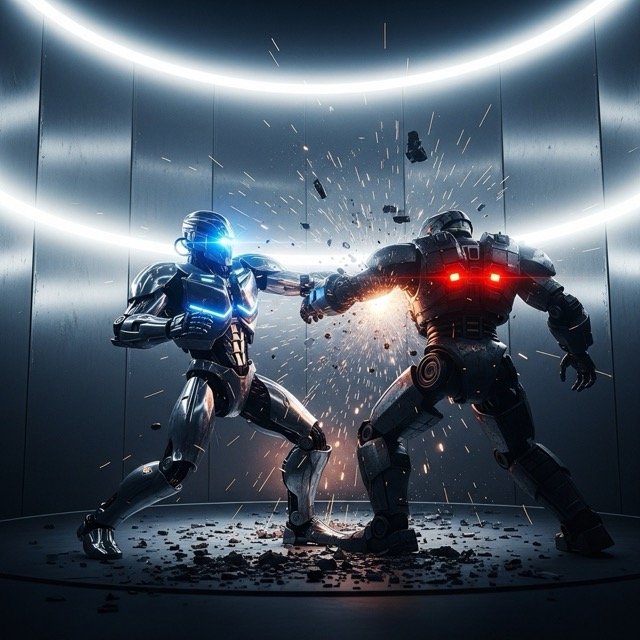

In [21]:
from sklearn.metrics.pairwise import cosine_similarity


def search_multimodal(query_text: str, docs: list[dict], top_k: int = 3) -> list[Any]:
    """
    Search for most similar documents to query using direct Gemini client.

    This function embeds the query text and compares it against pre-computed embeddings
    of document descriptions to find the most semantically similar matches.

    Args:
        query_text: Text query to search for
        docs: List of document dictionaries containing embeddings and metadata
        top_k: Number of top results to return. Defaults to 3

    Returns:
        list[Any]: List of document dictionaries with similarity scores, sorted by relevance
    """

    print(f"\n🔍 Embedding query: '{query_text}'")

    query_embedding = embed_text_with_gemini(query_text)

    if query_embedding is None:
        print("❌ Failed to embed query")
        return []
    else:
        print("✅ Query embedded successfully")

    # Calculate similarities using our custom function
    embeddings = [doc["embedding"] for doc in docs]
    similarities = cosine_similarity([query_embedding], embeddings).flatten()

    # Get top results
    top_indices = np.argsort(similarities)[::-1][:top_k]  # type: ignore

    results = []
    for idx in top_indices.tolist():
        results.append({**docs[idx], "similarity": similarities[idx]})

    return results


query = "two robots fighting"
results = search_multimodal(query, all_docs, top_k=1)

if not results:
    pretty_print.wrapped("❌ No results found", title="❌")
else:
    result = results[0]

    pretty_print.wrapped(
        [
            f"Similarity {result['similarity']:.3f}",
            f"Filename {result['filename']}",
            f"Description `{result['description'][:1000]}...`",
        ],
        title=f"Results for query = {query}",
    )
    display_image(Path(result["filename"]))


🔍 Embedding query: 'a kitten with a robot'
✅ Query embedded successfully
---------------------------- Results for query = a kitten with a robot ----------------------------
  Similarity 0.811
----------------------------------------------------------------------------------------------------
  Filename images/image_1.jpeg
----------------------------------------------------------------------------------------------------
  Description `This image depicts a striking juxtaposition of advanced technology and innocent nature, featuring a formidable, futuristic robot interacting with a tiny, adorable kitten in an industrial setting.

**Objects:**
*   **Robot:** A large, humanoid, bipedal robot dominates the right side of the frame. It is constructed from dark, metallic materials, appearing to be gunmetal grey or dark silver, with a brushed or polished finish. Its design is highly detailed, featuring segmented plating, exposed mechanical joints, rivets, bolts, and intricate wiring or circui

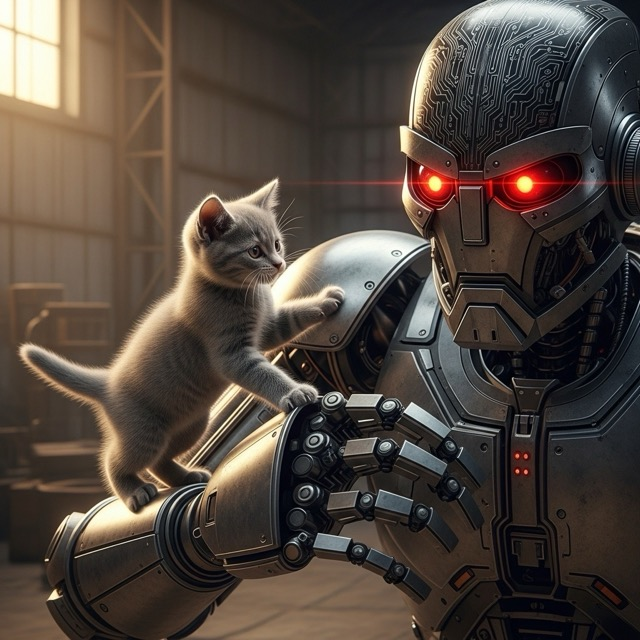

In [22]:
query = "a kitten with a robot"
results = search_multimodal(query, all_docs, top_k=1)

if not results:
    pretty_print.wrapped("❌ No results found", title="❌")
else:
    result = results[0]

    pretty_print.wrapped(
        [
            f"Similarity {result['similarity']:.3f}",
            f"Filename {result['filename']}",
            f"Description `{result['description'][:1000]}...`",
        ],
        title=f"Results for query = {query}",
    )
    display_image(Path(result["filename"]))

## 4. Building multimodal AI agents

In [23]:
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.prebuilt import create_react_agent


@tool
def multimodal_search_tool(query: str) -> dict[str, Any]:
    """
    Search through a collection of images and their text descriptions to find relevant content.

    This tool searches through a pre-indexed collection of image-text pairs using the query
    and returns the most relevant match. The search uses multimodal embeddings to find
    semantic matches between the query and the content.

    Args:
        query: Text query describing what to search for (e.g., "cat", "kitten with robot")

    Returns:
        A formatted string containing the search result with description and similarity score
    """

    pretty_print.wrapped(query, title="🔍 Tool executing search for:")

    results = search_multimodal(query, all_docs, top_k=1)

    if not results:
        return {"role": "tool_result", "content": "No relevant content found for your query."}
    else:
        pretty_print.wrapped(str(results[0]["filename"]), title="🔍 Found results:")
    result = results[0]

    content = [
        {
            "type": "text",
            "text": f"Image description: {result['description']}",
        },
        types.Part.from_bytes(
            data=result["content"],
            mime_type="image/jpeg",
        ),
    ]

    return {
        "role": "tool_result",
        "content": content,
    }

In [24]:
def build_react_agent() -> Any:
    """
    Build a ReAct agent with multimodal search capabilities.

    This function creates a LangGraph ReAct agent that can search through images
    and text using the multimodal_search_tool. The agent uses Gemini 2.5 Pro
    for reasoning and tool execution.

    Returns:
        Any: A LangGraph ReAct agent instance configured with multimodal search tools
    """

    tools = [multimodal_search_tool]

    system_prompt = """You are a helpful AI assistant that can search through images and text to answer questions.
    
    When asked about visual content like animals, objects, or scenes:
    1. Use the multimodal_search_tool to find relevant images and descriptions
    2. Carefully analyze the image or image descriptions from the search results
    3. Look for specific details like colors, features, objects, or characteristics
    4. Provide a clear, direct answer based on the search results
    5. If you can't find the specific information requested, be honest about limitations
    
    Pay special attention to:
    - Colors and visual characteristics
    - Animal features and breeds
    - Objects and their properties
    - Scene descriptions and context
    
    Always search first using your tools before attempting to answer questions about specific images or visual content.
    """

    agent = create_react_agent(
        model=ChatGoogleGenerativeAI(model="gemini-2.5-pro", temperature=0.1),
        tools=tools,
        prompt=system_prompt,
    )

    return agent


try:
    react_agent = build_react_agent()

    test_question = "what color is my kitten?"
    pretty_print.wrapped(test_question, title="🧪 Asking question:")

    response = react_agent.invoke(input={"messages": test_question})
    messages = response.get("messages", [])
    if messages:
        final_message = messages[-1].content
    else:
        final_message = "No response from the agent"
    pretty_print.wrapped(final_message, title="🤖 Agent response")
except Exception as e:
    print(f"❌ Error in ReAct agent: {e}")

---------------------------------------- 🧪 Asking question: ----------------------------------------
  what color is my kitten?
----------------------------------------------------------------------------------------------------
----------------------------------- 🔍 Tool executing search for: -----------------------------------
  my kitten
----------------------------------------------------------------------------------------------------

🔍 Embedding query: 'my kitten'
✅ Query embedded successfully
----------------------------------------- 🔍 Found results: -----------------------------------------
  images/image_1.jpeg
----------------------------------------------------------------------------------------------------
----------------------------------------- 🤖 Agent response -----------------------------------------
  Your kitten is a light grey tabby.
----------------------------------------------------------------------------------------------------
